# Introduction

based on : https://github.com/bentrevett/pytorch-seq2seq

Task : De-EN Translation    
Method : seq2seq  
Dataset : 'bentrevett' custom dataset

Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." Advances in neural information processing systems 27 (2014).   
Link : https://arxiv.org/pdf/1409.3215    

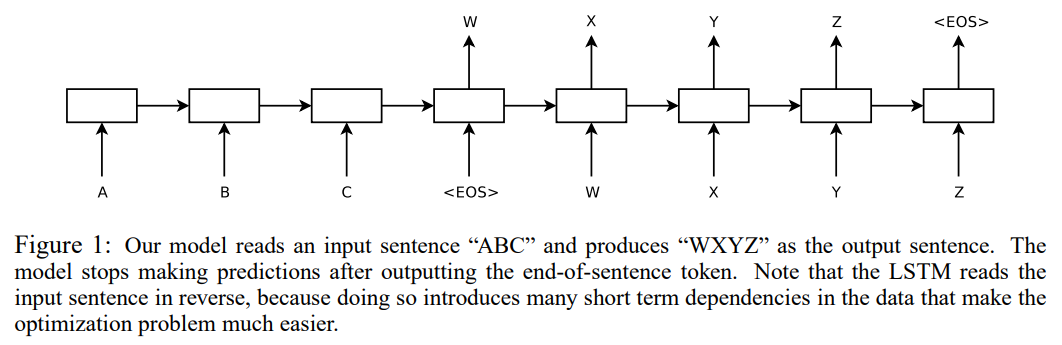

# 0. Set Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.tensorboard import SummaryWriter

from torch import Tensor
from typing import List, Dict, Tuple, Union, Annotated

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
import spacy
import random
import datetime

import evaluate
import datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

Selected device: cuda


In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
model_dir = './models/seq2seq_Translation_model.pth'

In [5]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time

        time_obj = datetime.timedelta(seconds= int(execution_time))
        
        print(f"Function '{func.__name__}' Execution Time {time_obj}")
        return result
    return wrapper

# 1. Data processing

## 1-1. Get Data

In [6]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [7]:
train_data, valid_data, test_data = (dataset["train"],
                                     dataset["validation"],
                                     dataset["test"])

In [8]:
print(train_data, valid_data, test_data)

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})


In [9]:
pprint(train_data[0])

{'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en': 'Two young, White males are outside near many bushes.'}


## 1-2. Tokenize

In [10]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [11]:
print(en_nlp)

In [12]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [13]:
max_length = 256

lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {"en_nlp": en_nlp,
             "de_nlp": de_nlp,
             "max_length": max_length,
             "lower": lower,
             "sos_token": sos_token,
             "eos_token": eos_token}

train_data = train_data.map(tokenize_example, fn_kwargs = fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs = fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs = fn_kwargs)

In [14]:
print(train_data, valid_data, test_data)

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens'],
    num_rows: 1000
})


In [15]:
pprint(train_data[0])

{'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'de_tokens': ['<sos>',
               'zwei',
               'junge',
               'weiße',
               'männer',
               'sind',
               'im',
               'freien',
               'in',
               'der',
               'nähe',
               'vieler',
               'büsche',
               '.',
               '<eos>'],
 'en': 'Two young, White males are outside near many bushes.',
 'en_tokens': ['<sos>',
               'two',
               'young',
               ',',
               'white',
               'males',
               'are',
               'outside',
               'near',
               'many',
               'bushes',
               '.',
               '<eos>']}


## 1-3. Build Vocab 

In [16]:
min_freq = 1
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [unk_token,
                  pad_token,
                  sos_token,
                  eos_token]

en_vocab = build_vocab_from_iterator(train_data["en_tokens"],
                                     min_freq = min_freq,
                                     specials = special_tokens)

de_vocab = build_vocab_from_iterator(train_data["de_tokens"],
                                     min_freq = min_freq,
                                     specials = special_tokens)

In [17]:
len(en_vocab), len(de_vocab)

(9797, 18669)

In [18]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [19]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [20]:
tokens = ["i", "love", "watching", "crime", "shows"]

In [21]:
en_vocab.lookup_indices(tokens)

[956, 2169, 173, 6799, 821]

In [22]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', 'crime', 'shows']

## 1-4. Numericalize Text

In [23]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [24]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs = fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs = fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs = fn_kwargs)

In [25]:
print(train_data, valid_data, test_data)

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 1000
})


In [26]:
pprint(train_data[0])

{'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3],
 'de_tokens': ['<sos>',
               'zwei',
               'junge',
               'weiße',
               'männer',
               'sind',
               'im',
               'freien',
               'in',
               'der',
               'nähe',
               'vieler',
               'büsche',
               '.',
               '<eos>'],
 'en': 'Two young, White males are outside near many bushes.',
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'en_tokens': ['<sos>',
               'two',
               'young',
               ',',
               'white',
               'males',
               'are',
               'outside',
               'near',
               'many',
               'bushes',
               '.',
               '<eos>']}


In [56]:

data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(type = data_type, 
                                    columns = format_columns, 
                                    output_all_columns = False)

valid_data = valid_data.with_format(type = data_type,
                                    columns = format_columns,
                                    output_all_columns = False)

test_data = test_data.with_format(type = data_type,
                                  columns = format_columns,
                                  output_all_columns = True)

In [28]:
print(train_data, valid_data, test_data)

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 1000
})


In [29]:
pprint(train_data[0])

{'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
        3171,    4,    3]),
 'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
           3])}


## 1-6. Prepare for Data Loading

In [30]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return item

In [31]:
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [32]:
def custom_collate_fn(batch):

    batch_en_ids = [sample["en_ids"] for sample in batch]
    batch_de_ids = [sample["de_ids"] for sample in batch]

    collate_en = pad_sequence(batch_en_ids,
                              padding_value = pad_index,
                              batch_first = True)
    collate_de = pad_sequence(batch_de_ids,
                              padding_value = pad_index,
                              batch_first = True)
    
    batch = {"en_ids": collate_en,
             "de_ids": collate_de}
    
    return batch

In [33]:
batch_size = 128
pad_index = pad_index
shuffle = True

trainloader = DataLoader(dataset = train_dataset,
                         batch_size = batch_size,
                         collate_fn = custom_collate_fn,
                         shuffle = shuffle)

validloader = DataLoader(dataset = train_dataset,
                         batch_size = batch_size,
                         collate_fn = custom_collate_fn,
                         shuffle = shuffle)

testloader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         collate_fn = custom_collate_fn,
                         shuffle = shuffle)

# 2. Define Model

## 2-1. Model Structure

In [34]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 embedding_dim: int, 
                 hidden_dim: int, 
                 num_layers: int, 
                 dropout_rate: float, 
                 pad_idx: int):
        
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(num_embeddings=self.input_dim, 
                                      embedding_dim=self.embedding_dim, 
                                      padding_idx=self.pad_idx)
        
        self.LSTM = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.num_layers, 
                            dropout=self.dropout_rate, 
                            batch_first=True)
        
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, 
                inputs: Annotated[Tensor, 'batch_size, seq_length'],
                h0:     Annotated[Tensor, 'num_layers, batch_size, hidden_dim'],
                c0:     Annotated[Tensor, 'num_layers, batch_size, hidden_dim']) -> Tuple[Annotated[Tensor, 'num_layers, batch_size, hidden_dim'], 
                                                                                          Annotated[Tensor, 'num_layers, batch_size, hidden_dim']]:

        # x: Tensor, 'batch_size, seq_length, embedding_dim'
        x = self.dropout(self.embedding(inputs))

        # output: Tensor, 'batch_size, seq_length, hidden_dim'
        # h: Tensor, 'num_layers, batch_size, hidden_dim'
        # c: Tensor, 'num_layers, batch_size, hidden_dim'
        output, (h, c) = self.LSTM(x, (h0, c0))
        
        return h, c

In [35]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim: int, 
                 embedding_dim: int, 
                 hidden_dim: int, 
                 num_layers: int, 
                 dropout_rate: float, 
                 pad_idx: int):
        
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.pad_idx = pad_idx
        
        self.embedding = nn.Embedding(num_embeddings=self.output_dim, 
                                      embedding_dim=self.embedding_dim, 
                                      padding_idx=self.pad_idx)
        
        self.LSTM = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.num_layers, 
                            dropout=self.dropout_rate, 
                            batch_first=True)
        
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
        self.fc = nn.Linear(in_features=self.hidden_dim, 
                            out_features=self.output_dim)

    def forward(self, 
                inputs: Annotated[Tensor, "batch_size, 1"], 
                h:      Annotated[Tensor, "num_layers, batch_size, hidden_dim"], 
                c:      Annotated[Tensor, "num_layers, batch_size, hidden_dim"]) -> Tuple[Annotated[Tensor, "logit : batch_size, 1, output_dim"],
                                                                                          Annotated[Tensor, "h : num_layers, batch_size, hidden_dim"],
                                                                                          Annotated[Tensor, "c : num_layers, batch_size, hidden_dim"]]:

        # x: Tensor, 'batch_size, 1, embedding_dim'
        x = self.dropout(self.embedding(inputs))
        
        # output: Tensor, 'batch_size, 1, hidden_dim'
        # h: Tensor, 'num_layers, batch_size, hidden_dim' 
        # c: Tensor, 'num_layers, batch_size, hidden_dim' 
        output, (h, c) = self.LSTM(x, (h, c))

        # logit: Tensor, 'batch_size, 1, output_dim'
        logit = self.fc(output)

        return logit, h, c

In [36]:
class seq2seq_Translation(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.Encoder = encoder
        self.Decoder = decoder

        assert (
            self.Encoder.hidden_dim == self.Decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            self.Encoder.num_layers == self.Decoder.num_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, 
                source: Annotated[Tensor, 'batch_size, seq_length'], 
                target: Annotated[Tensor, 'batch_size, seq_length'], 
                teacher_forcing_ratio: float)                       -> Annotated[Tensor, 'batch_size, seq_length, output_dim']:

        target_batch_size = target.size(0)
        target_seq_length = target.size(1)
        target_vocab_size = self.Decoder.output_dim

        source_batch_size = source.size(0)

        logit_seq = torch.zeros(target_batch_size, target_seq_length, target_vocab_size).to(device)

        h0 = torch.zeros(self.Encoder.num_layers, source_batch_size, self.Encoder.hidden_dim).to(device)
        c0 = torch.zeros(self.Encoder.num_layers, source_batch_size, self.Encoder.hidden_dim).to(device)

        # h_encoder: Tensor, 'num_layers, batch_size, hidden_dim'
        # c_encoder: Tensor, 'num_layers, batch_size, hidden_dim'         
        h_encoder, c_encoder = self.Encoder(source, h0, c0)

        # x: Tensor, 'batch_size, seq_length = 1'
        x = target[:, 0].unsqueeze(1)

        h, c = h_encoder, c_encoder
        for t in range(1, target_seq_length):

            # logit: Tensor, 'batch_size, seq_length = 1, output_dim'
            # h: Tensor, 'num_layers, batch_size, hidden_dim'
            # c: Tensor, 'num_layers, batch_size, hidden_dim'
            logit, h, c = self.Decoder(x, h, c)

            # logit_seq: Tensor, 'batch_size, seq_length, output_dim'
            logit_seq[:, t, :] = logit.squeeze(1)
            
            teacher_force = random.random() < teacher_forcing_ratio

            # predicted_vocab: Tensor, 'batch_size, seq_length = 1'
            predicted_vocab = logit.argmax(2)

            # x: Tensor, 'batch_size, seq_length = 1'
            x = target[:, t].unsqueeze(1) if teacher_force else predicted_vocab

        return logit_seq

## 2-2. Hyperparameter & functions

In [37]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 300
decoder_embedding_dim = 300
hidden_dim = 128
num_layers = 3
encoder_dropout = 0.5
decoder_dropout = 0.5
pad_index = pad_index
lr = 5e-4

encoder = Encoder(input_dim= input_dim,
                  embedding_dim= encoder_embedding_dim,
                  hidden_dim= hidden_dim,
                  num_layers= num_layers,
                  dropout_rate= encoder_dropout,
                  pad_idx= pad_index)

decoder = Decoder(output_dim= output_dim,
                  embedding_dim= decoder_embedding_dim,
                  hidden_dim= hidden_dim,
                  num_layers= num_layers,
                  dropout_rate= decoder_dropout,
                  pad_idx= pad_index)

model = seq2seq_Translation(encoder, decoder)

criterion = nn.CrossEntropyLoss(ignore_index= pad_index)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## 2-3. Weight Initialization

In [38]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            torch.nn.init.xavier_uniform_(param)
        if 'bias' in name:
            nn.init.constant_(param, 0.0)

In [39]:
model.apply(initialize_weights)

seq2seq_Translation(
  (Encoder): Encoder(
    (embedding): Embedding(18669, 300, padding_idx=1)
    (LSTM): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Decoder): Decoder(
    (embedding): Embedding(9797, 300, padding_idx=1)
    (LSTM): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=128, out_features=9797, bias=True)
  )
)

In [40]:
pprint("Model's state_dict:")
for name, param in model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"    Size : {param.size()}")
    print(f"    Value: {param}")

"Model's state_dict:"
Parameter name: Encoder.embedding.weight
    Size : torch.Size([18669, 300])
    Value: Parameter containing:
tensor([[-0.0125, -0.0136, -0.0065,  ...,  0.0096,  0.0156,  0.0078],
        [-0.0152, -0.0018, -0.0048,  ..., -0.0144,  0.0097,  0.0023],
        [-0.0164,  0.0071, -0.0119,  ..., -0.0091, -0.0071, -0.0144],
        ...,
        [-0.0149, -0.0099, -0.0168,  ...,  0.0008,  0.0028, -0.0002],
        [ 0.0003,  0.0158, -0.0031,  ...,  0.0062, -0.0098, -0.0009],
        [ 0.0010,  0.0108, -0.0036,  ...,  0.0078,  0.0086,  0.0156]],
       requires_grad=True)
Parameter name: Encoder.LSTM.weight_ih_l0
    Size : torch.Size([512, 300])
    Value: Parameter containing:
tensor([[ 0.0136, -0.0091, -0.0734,  ..., -0.0526, -0.0320,  0.0484],
        [ 0.0545, -0.0651,  0.0425,  ..., -0.0609, -0.0191, -0.0212],
        [ 0.0848,  0.0025, -0.0678,  ..., -0.0686,  0.0453,  0.0821],
        ...,
        [ 0.0106,  0.0155,  0.0696,  ..., -0.0295,  0.0473, -0.0385],
     

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,772,317 trainable parameters


In [42]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

# 3. Train Model

In [43]:
def train_fn(model, trainloader, criterion, optimizer, clip, teacher_forcing_ratio):
        
    model.train()
    
    running_loss = 0.0
    
    for batch in tqdm(trainloader):
        
        # source: Tensor, 'batch_size, seq_length'
        # target: Tensor, 'batch_size, seq_length'
        source = batch['de_ids'].to(device)
        target = batch['en_ids'].to(device)
        
        optimizer.zero_grad()

        # logit_seq: Tensor, 'batch_size, seq_length, output_dim'
        logit_seq = model(source = source, 
                          target = target, 
                          teacher_forcing_ratio = teacher_forcing_ratio)
        
        output_dim = model.Decoder.output_dim

        # logits = 'batch_size * seq_length - 1), output_dim'
        # target: Tensor, 'batch_size * (seq_length - 1)'
        logits = logit_seq[:, 1:, :].reshape(-1, output_dim)
        target = target[:, 1:].reshape(-1)

        loss = criterion(logits, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        running_loss += loss.item() * source.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)
    
    return epoch_loss

In [44]:
def evaluate_fn(model, validloader, criterion, teacher_forcing_ratio):
    
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(validloader):

            # source: Tensor, 'batch_size, seq_length'
            # target: Tensor, 'batch_size, seq_length'
            source = batch['de_ids'].to(device)
            target = batch['en_ids'].to(device)

            # logit_seq: Tensor, 'batch_size, seq_length, output_dim'
            logit_seq = model(source = source, 
                              target = target, 
                              teacher_forcing_ratio = teacher_forcing_ratio)

            output_dim = model.Decoder.output_dim

            # logits: Tensor, 'batch_size * (seq_length - 1), output_dim'
            # target: Tensor, 'batch_size * (seq_length - 1)'
            logits = logit_seq[:, 1:, :].reshape(-1, output_dim)
            target = target[:, 1:].reshape(-1)

            loss = criterion(logits, target)
            
            running_loss += loss.item() * source.size(0)
        
        epoch_loss = running_loss / len(validloader.dataset)
        
    return epoch_loss

In [45]:
@timeit
def train_model(model, criterion, optimizer, trainloader, validloader, clip, teacher_forcing_ratio, num_epochs):
    print("-----Training Started------")

    best_valid_loss = float("inf")
    
    for epoch in range(num_epochs):

        print(f"Epoch [{epoch+1}/{num_epochs}]")
              
        train_loss = train_fn(model= model,
                              trainloader= trainloader,
                              criterion= criterion,
                              optimizer= optimizer,
                              clip = clip,
                              teacher_forcing_ratio= teacher_forcing_ratio)
        
        valid_loss = evaluate_fn(model= model,
                                 validloader= validloader,
                                 criterion= criterion,
                                 teacher_forcing_ratio= 0.0)

        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss

            torch.save(model.state_dict(), model_dir)
            
        print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
        print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    
    print("-----Training Completed-----")

In [46]:
num_epochs = 128

clip = 1.0
teacher_forcing_ratio = 0.5

train_model(model, criterion, optimizer, trainloader, validloader, clip, teacher_forcing_ratio, num_epochs)

-----Training Started------
Epoch [1/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   5.968 | Train PPL: 390.762
	Valid Loss:   5.385 | Valid PPL: 218.079
Epoch [2/128]


100%|██████████| 227/227 [00:17<00:00, 13.31it/s]


	Train Loss:   5.325 | Train PPL: 205.496
	Valid Loss:   5.251 | Valid PPL: 190.793
Epoch [3/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   5.235 | Train PPL: 187.699
	Valid Loss:   5.168 | Valid PPL: 175.602
Epoch [4/128]


100%|██████████| 227/227 [00:17<00:00, 13.32it/s]


	Train Loss:   5.123 | Train PPL: 167.860
	Valid Loss:   5.050 | Valid PPL: 156.067
Epoch [5/128]


100%|██████████| 227/227 [00:16<00:00, 13.39it/s]


	Train Loss:   4.975 | Train PPL: 144.699
	Valid Loss:   5.000 | Valid PPL: 148.481
Epoch [6/128]


100%|██████████| 227/227 [00:16<00:00, 13.44it/s]


	Train Loss:   4.822 | Train PPL: 124.260
	Valid Loss:   5.008 | Valid PPL: 149.579
Epoch [7/128]


100%|██████████| 227/227 [00:17<00:00, 13.29it/s]


	Train Loss:   4.710 | Train PPL: 111.092
	Valid Loss:   4.889 | Valid PPL: 132.791
Epoch [8/128]


100%|██████████| 227/227 [00:17<00:00, 13.32it/s]


	Train Loss:   4.597 | Train PPL:  99.154
	Valid Loss:   4.829 | Valid PPL: 125.148
Epoch [9/128]


100%|██████████| 227/227 [00:16<00:00, 13.47it/s]


	Train Loss:   4.485 | Train PPL:  88.689
	Valid Loss:   4.787 | Valid PPL: 119.986
Epoch [10/128]


100%|██████████| 227/227 [00:17<00:00, 13.25it/s]


	Train Loss:   4.406 | Train PPL:  81.978
	Valid Loss:   4.702 | Valid PPL: 110.146
Epoch [11/128]


100%|██████████| 227/227 [00:17<00:00, 13.25it/s]


	Train Loss:   4.333 | Train PPL:  76.179
	Valid Loss:   4.666 | Valid PPL: 106.269
Epoch [12/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   4.271 | Train PPL:  71.603
	Valid Loss:   4.627 | Valid PPL: 102.191
Epoch [13/128]


100%|██████████| 227/227 [00:17<00:00, 13.33it/s]


	Train Loss:   4.217 | Train PPL:  67.799
	Valid Loss:   4.622 | Valid PPL: 101.687
Epoch [14/128]


100%|██████████| 227/227 [00:17<00:00, 13.27it/s]


	Train Loss:   4.179 | Train PPL:  65.279
	Valid Loss:   4.560 | Valid PPL:  95.578
Epoch [15/128]


100%|██████████| 227/227 [00:17<00:00, 13.30it/s]


	Train Loss:   4.132 | Train PPL:  62.281
	Valid Loss:   4.530 | Valid PPL:  92.760
Epoch [16/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   4.088 | Train PPL:  59.625
	Valid Loss:   4.477 | Valid PPL:  87.967
Epoch [17/128]


100%|██████████| 227/227 [00:17<00:00, 13.25it/s]


	Train Loss:   4.050 | Train PPL:  57.423
	Valid Loss:   4.455 | Valid PPL:  86.024
Epoch [18/128]


100%|██████████| 227/227 [00:17<00:00, 13.33it/s]


	Train Loss:   4.010 | Train PPL:  55.165
	Valid Loss:   4.426 | Valid PPL:  83.557
Epoch [19/128]


100%|██████████| 227/227 [00:16<00:00, 13.40it/s]


	Train Loss:   3.980 | Train PPL:  53.536
	Valid Loss:   4.380 | Valid PPL:  79.850
Epoch [20/128]


100%|██████████| 227/227 [00:16<00:00, 13.37it/s]


	Train Loss:   3.954 | Train PPL:  52.147
	Valid Loss:   4.346 | Valid PPL:  77.143
Epoch [21/128]


100%|██████████| 227/227 [00:17<00:00, 13.31it/s]


	Train Loss:   3.914 | Train PPL:  50.091
	Valid Loss:   4.307 | Valid PPL:  74.210
Epoch [22/128]


100%|██████████| 227/227 [00:17<00:00, 13.19it/s]


	Train Loss:   3.873 | Train PPL:  48.064
	Valid Loss:   4.288 | Valid PPL:  72.841
Epoch [23/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   3.830 | Train PPL:  46.056
	Valid Loss:   4.265 | Valid PPL:  71.163
Epoch [24/128]


100%|██████████| 227/227 [00:17<00:00, 13.27it/s]


	Train Loss:   3.814 | Train PPL:  45.352
	Valid Loss:   4.272 | Valid PPL:  71.650
Epoch [25/128]


100%|██████████| 227/227 [00:17<00:00, 13.24it/s]


	Train Loss:   3.776 | Train PPL:  43.635
	Valid Loss:   4.183 | Valid PPL:  65.587
Epoch [26/128]


100%|██████████| 227/227 [00:17<00:00, 13.17it/s]


	Train Loss:   3.745 | Train PPL:  42.321
	Valid Loss:   4.217 | Valid PPL:  67.857
Epoch [27/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   3.700 | Train PPL:  40.451
	Valid Loss:   4.160 | Valid PPL:  64.074
Epoch [28/128]


100%|██████████| 227/227 [00:17<00:00, 13.27it/s]


	Train Loss:   3.677 | Train PPL:  39.541
	Valid Loss:   4.125 | Valid PPL:  61.886
Epoch [29/128]


100%|██████████| 227/227 [00:17<00:00, 13.24it/s]


	Train Loss:   3.654 | Train PPL:  38.621
	Valid Loss:   4.112 | Valid PPL:  61.039
Epoch [30/128]


100%|██████████| 227/227 [00:17<00:00, 13.31it/s]


	Train Loss:   3.614 | Train PPL:  37.130
	Valid Loss:   4.063 | Valid PPL:  58.163
Epoch [31/128]


100%|██████████| 227/227 [00:17<00:00, 13.24it/s]


	Train Loss:   3.569 | Train PPL:  35.487
	Valid Loss:   4.057 | Valid PPL:  57.816
Epoch [32/128]


100%|██████████| 227/227 [00:17<00:00, 13.17it/s]


	Train Loss:   3.551 | Train PPL:  34.836
	Valid Loss:   3.973 | Valid PPL:  53.153
Epoch [33/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   3.498 | Train PPL:  33.045
	Valid Loss:   3.996 | Valid PPL:  54.372
Epoch [34/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   3.470 | Train PPL:  32.152
	Valid Loss:   3.952 | Valid PPL:  52.037
Epoch [35/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   3.421 | Train PPL:  30.612
	Valid Loss:   3.904 | Valid PPL:  49.588
Epoch [36/128]


100%|██████████| 227/227 [00:17<00:00, 13.21it/s]


	Train Loss:   3.410 | Train PPL:  30.272
	Valid Loss:   3.899 | Valid PPL:  49.349
Epoch [37/128]


100%|██████████| 227/227 [00:17<00:00, 13.24it/s]


	Train Loss:   3.382 | Train PPL:  29.438
	Valid Loss:   3.833 | Valid PPL:  46.181
Epoch [38/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   3.361 | Train PPL:  28.832
	Valid Loss:   3.811 | Valid PPL:  45.196
Epoch [39/128]


100%|██████████| 227/227 [00:17<00:00, 13.21it/s]


	Train Loss:   3.322 | Train PPL:  27.720
	Valid Loss:   3.795 | Valid PPL:  44.459
Epoch [40/128]


100%|██████████| 227/227 [00:16<00:00, 13.36it/s]


	Train Loss:   3.292 | Train PPL:  26.897
	Valid Loss:   3.747 | Valid PPL:  42.409
Epoch [41/128]


100%|██████████| 227/227 [00:17<00:00, 13.27it/s]


	Train Loss:   3.263 | Train PPL:  26.125
	Valid Loss:   3.828 | Valid PPL:  45.970
Epoch [42/128]


100%|██████████| 227/227 [00:17<00:00, 13.10it/s]


	Train Loss:   3.252 | Train PPL:  25.850
	Valid Loss:   3.717 | Valid PPL:  41.152
Epoch [43/128]


100%|██████████| 227/227 [00:17<00:00, 13.16it/s]


	Train Loss:   3.218 | Train PPL:  24.979
	Valid Loss:   3.702 | Valid PPL:  40.523
Epoch [44/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   3.210 | Train PPL:  24.777
	Valid Loss:   3.708 | Valid PPL:  40.763
Epoch [45/128]


100%|██████████| 227/227 [00:17<00:00, 13.14it/s]


	Train Loss:   3.160 | Train PPL:  23.571
	Valid Loss:   3.659 | Valid PPL:  38.824
Epoch [46/128]


100%|██████████| 227/227 [00:17<00:00, 13.13it/s]


	Train Loss:   3.144 | Train PPL:  23.206
	Valid Loss:   3.644 | Valid PPL:  38.248
Epoch [47/128]


100%|██████████| 227/227 [00:17<00:00, 13.19it/s]


	Train Loss:   3.142 | Train PPL:  23.150
	Valid Loss:   3.572 | Valid PPL:  35.572
Epoch [48/128]


100%|██████████| 227/227 [00:17<00:00, 13.15it/s]


	Train Loss:   3.090 | Train PPL:  21.973
	Valid Loss:   3.598 | Valid PPL:  36.541
Epoch [49/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   3.084 | Train PPL:  21.855
	Valid Loss:   3.574 | Valid PPL:  35.673
Epoch [50/128]


100%|██████████| 227/227 [00:17<00:00, 13.15it/s]


	Train Loss:   3.073 | Train PPL:  21.603
	Valid Loss:   3.549 | Valid PPL:  34.777
Epoch [51/128]


100%|██████████| 227/227 [00:17<00:00, 13.17it/s]


	Train Loss:   3.043 | Train PPL:  20.963
	Valid Loss:   3.520 | Valid PPL:  33.782
Epoch [52/128]


100%|██████████| 227/227 [00:17<00:00, 13.31it/s]


	Train Loss:   3.001 | Train PPL:  20.103
	Valid Loss:   3.488 | Valid PPL:  32.735
Epoch [53/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   3.009 | Train PPL:  20.277
	Valid Loss:   3.523 | Valid PPL:  33.894
Epoch [54/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   2.981 | Train PPL:  19.716
	Valid Loss:   3.463 | Valid PPL:  31.903
Epoch [55/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   2.959 | Train PPL:  19.278
	Valid Loss:   3.426 | Valid PPL:  30.756
Epoch [56/128]


100%|██████████| 227/227 [00:17<00:00, 13.15it/s]


	Train Loss:   2.952 | Train PPL:  19.152
	Valid Loss:   3.396 | Valid PPL:  29.834
Epoch [57/128]


100%|██████████| 227/227 [00:17<00:00, 13.29it/s]


	Train Loss:   2.930 | Train PPL:  18.728
	Valid Loss:   3.367 | Valid PPL:  28.982
Epoch [58/128]


100%|██████████| 227/227 [00:17<00:00, 13.16it/s]


	Train Loss:   2.904 | Train PPL:  18.245
	Valid Loss:   3.396 | Valid PPL:  29.848
Epoch [59/128]


100%|██████████| 227/227 [00:17<00:00, 13.27it/s]


	Train Loss:   2.884 | Train PPL:  17.879
	Valid Loss:   3.380 | Valid PPL:  29.367
Epoch [60/128]


100%|██████████| 227/227 [00:17<00:00, 13.28it/s]


	Train Loss:   2.864 | Train PPL:  17.537
	Valid Loss:   3.361 | Valid PPL:  28.819
Epoch [61/128]


100%|██████████| 227/227 [00:17<00:00, 13.34it/s]


	Train Loss:   2.855 | Train PPL:  17.378
	Valid Loss:   3.326 | Valid PPL:  27.840
Epoch [62/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   2.841 | Train PPL:  17.129
	Valid Loss:   3.279 | Valid PPL:  26.543
Epoch [63/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   2.814 | Train PPL:  16.670
	Valid Loss:   3.276 | Valid PPL:  26.459
Epoch [64/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   2.809 | Train PPL:  16.586
	Valid Loss:   3.294 | Valid PPL:  26.948
Epoch [65/128]


100%|██████████| 227/227 [00:17<00:00, 13.21it/s]


	Train Loss:   2.782 | Train PPL:  16.159
	Valid Loss:   3.234 | Valid PPL:  25.383
Epoch [66/128]


100%|██████████| 227/227 [00:17<00:00, 13.22it/s]


	Train Loss:   2.761 | Train PPL:  15.809
	Valid Loss:   3.252 | Valid PPL:  25.853
Epoch [67/128]


100%|██████████| 227/227 [00:17<00:00, 13.14it/s]


	Train Loss:   2.736 | Train PPL:  15.430
	Valid Loss:   3.242 | Valid PPL:  25.576
Epoch [68/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   2.734 | Train PPL:  15.395
	Valid Loss:   3.213 | Valid PPL:  24.853
Epoch [69/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   2.712 | Train PPL:  15.055
	Valid Loss:   3.230 | Valid PPL:  25.270
Epoch [70/128]


100%|██████████| 227/227 [00:17<00:00, 13.14it/s]


	Train Loss:   2.714 | Train PPL:  15.085
	Valid Loss:   3.175 | Valid PPL:  23.921
Epoch [71/128]


100%|██████████| 227/227 [00:17<00:00, 13.20it/s]


	Train Loss:   2.698 | Train PPL:  14.854
	Valid Loss:   3.177 | Valid PPL:  23.979
Epoch [72/128]


100%|██████████| 227/227 [00:17<00:00, 13.15it/s]


	Train Loss:   2.678 | Train PPL:  14.557
	Valid Loss:   3.144 | Valid PPL:  23.207
Epoch [73/128]


100%|██████████| 227/227 [00:17<00:00, 13.18it/s]


	Train Loss:   2.649 | Train PPL:  14.147
	Valid Loss:   3.194 | Valid PPL:  24.382
Epoch [74/128]


100%|██████████| 227/227 [00:17<00:00, 13.19it/s]


	Train Loss:   2.646 | Train PPL:  14.092
	Valid Loss:   3.095 | Valid PPL:  22.085
Epoch [75/128]


100%|██████████| 227/227 [00:17<00:00, 13.21it/s]


	Train Loss:   2.638 | Train PPL:  13.985
	Valid Loss:   3.092 | Valid PPL:  22.023
Epoch [76/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   2.622 | Train PPL:  13.756
	Valid Loss:   3.076 | Valid PPL:  21.664
Epoch [77/128]


100%|██████████| 227/227 [00:17<00:00, 13.15it/s]


	Train Loss:   2.613 | Train PPL:  13.635
	Valid Loss:   3.079 | Valid PPL:  21.743
Epoch [78/128]


100%|██████████| 227/227 [00:17<00:00, 13.33it/s]


	Train Loss:   2.589 | Train PPL:  13.321
	Valid Loss:   3.029 | Valid PPL:  20.671
Epoch [79/128]


100%|██████████| 227/227 [00:17<00:00, 13.23it/s]


	Train Loss:   2.578 | Train PPL:  13.171
	Valid Loss:   3.079 | Valid PPL:  21.731
Epoch [80/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   2.555 | Train PPL:  12.866
	Valid Loss:   3.032 | Valid PPL:  20.731
Epoch [81/128]


100%|██████████| 227/227 [00:17<00:00, 13.31it/s]


	Train Loss:   2.554 | Train PPL:  12.855
	Valid Loss:   3.031 | Valid PPL:  20.719
Epoch [82/128]


100%|██████████| 227/227 [00:17<00:00, 13.30it/s]


	Train Loss:   2.538 | Train PPL:  12.657
	Valid Loss:   3.039 | Valid PPL:  20.890
Epoch [83/128]


100%|██████████| 227/227 [00:17<00:00, 13.28it/s]


	Train Loss:   2.518 | Train PPL:  12.405
	Valid Loss:   3.010 | Valid PPL:  20.285
Epoch [84/128]


100%|██████████| 227/227 [00:17<00:00, 13.28it/s]


	Train Loss:   2.524 | Train PPL:  12.484
	Valid Loss:   2.975 | Valid PPL:  19.598
Epoch [85/128]


100%|██████████| 227/227 [00:17<00:00, 13.26it/s]


	Train Loss:   2.509 | Train PPL:  12.287
	Valid Loss:   2.986 | Valid PPL:  19.805
Epoch [86/128]


100%|██████████| 227/227 [00:17<00:00, 13.12it/s]


	Train Loss:   2.498 | Train PPL:  12.155
	Valid Loss:   2.976 | Valid PPL:  19.605
Epoch [87/128]


100%|██████████| 227/227 [00:17<00:00, 12.94it/s]


	Train Loss:   2.485 | Train PPL:  12.006
	Valid Loss:   2.916 | Valid PPL:  18.463
Epoch [88/128]


100%|██████████| 227/227 [00:17<00:00, 12.91it/s]


	Train Loss:   2.468 | Train PPL:  11.802
	Valid Loss:   2.924 | Valid PPL:  18.624
Epoch [89/128]


100%|██████████| 227/227 [00:17<00:00, 13.02it/s]


	Train Loss:   2.455 | Train PPL:  11.651
	Valid Loss:   2.921 | Valid PPL:  18.553
Epoch [90/128]


100%|██████████| 227/227 [00:17<00:00, 12.90it/s]


	Train Loss:   2.447 | Train PPL:  11.554
	Valid Loss:   2.893 | Valid PPL:  18.054
Epoch [91/128]


100%|██████████| 227/227 [00:17<00:00, 12.97it/s]


	Train Loss:   2.436 | Train PPL:  11.429
	Valid Loss:   2.905 | Valid PPL:  18.270
Epoch [92/128]


100%|██████████| 227/227 [00:17<00:00, 12.91it/s]


	Train Loss:   2.428 | Train PPL:  11.338
	Valid Loss:   2.859 | Valid PPL:  17.452
Epoch [93/128]


100%|██████████| 227/227 [00:17<00:00, 12.87it/s]


	Train Loss:   2.418 | Train PPL:  11.228
	Valid Loss:   2.811 | Valid PPL:  16.620
Epoch [94/128]


100%|██████████| 227/227 [00:17<00:00, 12.88it/s]


	Train Loss:   2.415 | Train PPL:  11.188
	Valid Loss:   2.833 | Valid PPL:  16.993
Epoch [95/128]


100%|██████████| 227/227 [00:17<00:00, 12.92it/s]


	Train Loss:   2.404 | Train PPL:  11.070
	Valid Loss:   2.818 | Valid PPL:  16.746
Epoch [96/128]


100%|██████████| 227/227 [00:17<00:00, 12.84it/s]


	Train Loss:   2.382 | Train PPL:  10.827
	Valid Loss:   2.825 | Valid PPL:  16.869
Epoch [97/128]


100%|██████████| 227/227 [00:17<00:00, 12.92it/s]


	Train Loss:   2.376 | Train PPL:  10.764
	Valid Loss:   2.793 | Valid PPL:  16.332
Epoch [98/128]


100%|██████████| 227/227 [00:17<00:00, 12.99it/s]


	Train Loss:   2.355 | Train PPL:  10.539
	Valid Loss:   2.776 | Valid PPL:  16.049
Epoch [99/128]


100%|██████████| 227/227 [00:17<00:00, 12.90it/s]


	Train Loss:   2.346 | Train PPL:  10.439
	Valid Loss:   2.767 | Valid PPL:  15.910
Epoch [100/128]


100%|██████████| 227/227 [00:17<00:00, 12.97it/s]


	Train Loss:   2.344 | Train PPL:  10.420
	Valid Loss:   2.749 | Valid PPL:  15.629
Epoch [101/128]


100%|██████████| 227/227 [00:17<00:00, 12.84it/s]


	Train Loss:   2.324 | Train PPL:  10.217
	Valid Loss:   2.757 | Valid PPL:  15.748
Epoch [102/128]


100%|██████████| 227/227 [00:17<00:00, 12.90it/s]


	Train Loss:   2.328 | Train PPL:  10.258
	Valid Loss:   2.731 | Valid PPL:  15.346
Epoch [103/128]


100%|██████████| 227/227 [00:17<00:00, 12.84it/s]


	Train Loss:   2.309 | Train PPL:  10.064
	Valid Loss:   2.726 | Valid PPL:  15.273
Epoch [104/128]


100%|██████████| 227/227 [00:17<00:00, 12.94it/s]


	Train Loss:   2.297 | Train PPL:   9.948
	Valid Loss:   2.694 | Valid PPL:  14.792
Epoch [105/128]


100%|██████████| 227/227 [00:17<00:00, 12.93it/s]


	Train Loss:   2.305 | Train PPL:  10.025
	Valid Loss:   2.673 | Valid PPL:  14.477
Epoch [106/128]


100%|██████████| 227/227 [00:17<00:00, 12.94it/s]


	Train Loss:   2.281 | Train PPL:   9.783
	Valid Loss:   2.692 | Valid PPL:  14.761
Epoch [107/128]


100%|██████████| 227/227 [00:17<00:00, 13.00it/s]


	Train Loss:   2.257 | Train PPL:   9.556
	Valid Loss:   2.703 | Valid PPL:  14.929
Epoch [108/128]


100%|██████████| 227/227 [00:17<00:00, 13.06it/s]


	Train Loss:   2.263 | Train PPL:   9.614
	Valid Loss:   2.652 | Valid PPL:  14.189
Epoch [109/128]


100%|██████████| 227/227 [00:17<00:00, 12.91it/s]


	Train Loss:   2.267 | Train PPL:   9.654
	Valid Loss:   2.602 | Valid PPL:  13.486
Epoch [110/128]


100%|██████████| 227/227 [00:17<00:00, 13.01it/s]


	Train Loss:   2.222 | Train PPL:   9.229
	Valid Loss:   2.678 | Valid PPL:  14.552
Epoch [111/128]


100%|██████████| 227/227 [00:17<00:00, 12.83it/s]


	Train Loss:   2.233 | Train PPL:   9.326
	Valid Loss:   2.636 | Valid PPL:  13.964
Epoch [112/128]


100%|██████████| 227/227 [00:17<00:00, 12.81it/s]


	Train Loss:   2.225 | Train PPL:   9.258
	Valid Loss:   2.573 | Valid PPL:  13.105
Epoch [113/128]


100%|██████████| 227/227 [00:17<00:00, 12.87it/s]


	Train Loss:   2.233 | Train PPL:   9.324
	Valid Loss:   2.586 | Valid PPL:  13.272
Epoch [114/128]


100%|██████████| 227/227 [00:17<00:00, 12.90it/s]


	Train Loss:   2.208 | Train PPL:   9.093
	Valid Loss:   2.568 | Valid PPL:  13.034
Epoch [115/128]


100%|██████████| 227/227 [00:17<00:00, 12.93it/s]


	Train Loss:   2.196 | Train PPL:   8.989
	Valid Loss:   2.605 | Valid PPL:  13.528
Epoch [116/128]


100%|██████████| 227/227 [00:17<00:00, 12.96it/s]


	Train Loss:   2.191 | Train PPL:   8.940
	Valid Loss:   2.537 | Valid PPL:  12.640
Epoch [117/128]


100%|██████████| 227/227 [00:17<00:00, 12.89it/s]


	Train Loss:   2.176 | Train PPL:   8.815
	Valid Loss:   2.559 | Valid PPL:  12.926
Epoch [118/128]


100%|██████████| 227/227 [00:17<00:00, 12.98it/s]


	Train Loss:   2.167 | Train PPL:   8.729
	Valid Loss:   2.563 | Valid PPL:  12.975
Epoch [119/128]


100%|██████████| 227/227 [00:17<00:00, 12.92it/s]


	Train Loss:   2.157 | Train PPL:   8.649
	Valid Loss:   2.534 | Valid PPL:  12.603
Epoch [120/128]


100%|██████████| 227/227 [00:17<00:00, 12.99it/s]


	Train Loss:   2.156 | Train PPL:   8.633
	Valid Loss:   2.538 | Valid PPL:  12.653
Epoch [121/128]


100%|██████████| 227/227 [00:17<00:00, 12.85it/s]


	Train Loss:   2.149 | Train PPL:   8.579
	Valid Loss:   2.532 | Valid PPL:  12.581
Epoch [122/128]


100%|██████████| 227/227 [00:17<00:00, 12.92it/s]


	Train Loss:   2.142 | Train PPL:   8.519
	Valid Loss:   2.514 | Valid PPL:  12.360
Epoch [123/128]


100%|██████████| 227/227 [00:17<00:00, 12.84it/s]


	Train Loss:   2.110 | Train PPL:   8.250
	Valid Loss:   2.524 | Valid PPL:  12.473
Epoch [124/128]


100%|██████████| 227/227 [00:17<00:00, 12.96it/s]


	Train Loss:   2.119 | Train PPL:   8.320
	Valid Loss:   2.513 | Valid PPL:  12.339
Epoch [125/128]


100%|██████████| 227/227 [00:17<00:00, 12.87it/s]


	Train Loss:   2.101 | Train PPL:   8.174
	Valid Loss:   2.480 | Valid PPL:  11.937
Epoch [126/128]


100%|██████████| 227/227 [00:17<00:00, 12.90it/s]


	Train Loss:   2.109 | Train PPL:   8.244
	Valid Loss:   2.463 | Valid PPL:  11.740
Epoch [127/128]


100%|██████████| 227/227 [00:17<00:00, 12.99it/s]


	Train Loss:   2.116 | Train PPL:   8.294
	Valid Loss:   2.467 | Valid PPL:  11.790
Epoch [128/128]


100%|██████████| 227/227 [00:17<00:00, 12.80it/s]

	Train Loss:   2.086 | Train PPL:   8.053
	Valid Loss:   2.445 | Valid PPL:  11.527
-----Training Completed-----
Function 'train_model' Execution Time 1:39:06


# 4. Test

In [47]:
test_loss = evaluate_fn(model, testloader, criterion, teacher_forcing_ratio = 0)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

100%|██████████| 8/8 [00:00<00:00, 12.90it/s]

| Test Loss: 4.178 | Test PPL:  65.247 |


# 5. Inference

In [66]:
def inference(model: nn.Module, 
              text: str, 
              en_nlp: spacy.language.Language, 
              de_nlp: spacy.language.Language, 
              en_vocab: torchtext.vocab.Vocab, 
              de_vocab: torchtext.vocab.Vocab, 
              sos_token: str, 
              eos_token: str,
              max_output_length: int = 32,
              lower: bool = True):

    model.eval()

    with torch.no_grad():
        # de_tokens: List[str], 'seq_length'
        # de_ids: List[int], 'seq_length'
        de_tokens = [sos_token] + [token.text for token in de_nlp.tokenizer(text)] + [eos_token]
        de_ids = de_vocab.lookup_indices(de_tokens)

        # source: Tensor, 'batch_size = 1, seq_length'
        source = torch.LongTensor(de_ids).unsqueeze(0).to(device)

        # h0: Tensor, 'num_layers, batch_size = 1, hidden_dim'
        # c0: Tensor, 'num_layers, batch_size = 1, hidden_dim'      
        h0 = torch.zeros(model.Encoder.num_layers, 1, model.Encoder.hidden_dim).to(device)
        c0 = torch.zeros(model.Encoder.num_layers, 1, model.Encoder.hidden_dim).to(device)

        # h_encoder: Tensor, 'num_layers, batch_size = 1, hidden_dim'
        # c_encoder: Tensor, 'num_layers, batch_size = 1, hidden_dim'       
        h_encoder, c_encoder = model.Encoder(source, h0, c0)

        # tokens_ids: List[int], '1'
        tokens_ids = en_vocab.lookup_indices([sos_token])
        h, c = h_encoder, c_encoder

        for _ in range(max_output_length):
            # input_tensor: Tensor, 'batch_size = 1, seq_length = 1'
            input_tensor = torch.LongTensor([tokens_ids[-1]]).unsqueeze(-1).to(device)
            
            # logit: Tensor, 'batch_size = 1, seq_length = 1, output_dim'
            # h: Tensor, 'num_layers, batch_size = 1, hidden_dim'
            # c: Tensor, 'num_layers, batch_sizee = 1, hidden_dim'
            logit, h, c = model.Decoder(input_tensor, h, c)

            # predicted_vocab: Tensor, 'batch_size = 1, seq_length = 1'
            # tokens_ids: List[int], 'output_length'
            predicted_vocab = logit.argmax(2).item()
            tokens_ids.append(predicted_vocab)

            if predicted_vocab == en_vocab[eos_token]:
                break
        
        # tokens: List[str], 'output_length'
        tokens = en_vocab.lookup_tokens(tokens_ids)

    return tokens

In [67]:
model = seq2seq_Translation(encoder, decoder)
model.load_state_dict(torch.load(model_dir))
model.to(device)

seq2seq_Translation(
  (Encoder): Encoder(
    (embedding): Embedding(18669, 300, padding_idx=1)
    (LSTM): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Decoder): Decoder(
    (embedding): Embedding(9797, 300, padding_idx=1)
    (LSTM): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=128, out_features=9797, bias=True)
  )
)

In [68]:
sentence = "Ein Mann sitzt auf einer Bank." 
            # A man is watching a film.

translated_tokens = inference(model= model,
                              text= sentence,
                              en_nlp= en_nlp,
                              de_nlp= de_nlp,
                              en_vocab= en_vocab,
                              de_vocab= de_vocab,
                              sos_token= sos_token,
                              eos_token= eos_token,
                              max_output_length= 32,
                              lower= True)

translated_sentence = ' '.join([token for token in translated_tokens if token not in ['<sos>', '<eos>', '.']])

print(translated_sentence)

a on on the floor


In [69]:
sentence = "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche." 
            # Two young, White males are outside near many bushes.

translated_tokens = inference(model= model,
                              text= sentence,
                              en_nlp= en_nlp,
                              de_nlp= de_nlp,
                              en_vocab= en_vocab,
                              de_vocab= de_vocab,
                              sos_token= sos_token,
                              eos_token= eos_token,
                              max_output_length= 32,
                              lower= True)

translated_sentence = ' '.join([token for token in translated_tokens if token not in ['<sos>', '<eos>', '.']])

print(translated_sentence)

the white boy is in the the in the


In [70]:
sentence = "Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt." 
            # A man in an orange hat starring at something.

translated_tokens = inference(model= model,
                              text= sentence,
                              en_nlp= en_nlp,
                              de_nlp= de_nlp,
                              en_vocab= en_vocab,
                              de_vocab= de_vocab,
                              sos_token= sos_token,
                              eos_token= eos_token,
                              max_output_length= 32,
                              lower= True)

translated_sentence = ' '.join([token for token in translated_tokens if token not in ['<sos>', '<eos>', '.']])

print(translated_sentence)

an orange in orange orange is the


## Evaluate

In [71]:
bleu = evaluate.load("bleu")

In [72]:
translations = [inference(model= model,
                          text= example['de'],
                          en_nlp= en_nlp,
                          de_nlp= de_nlp,
                          en_vocab= en_vocab,
                          de_vocab= de_vocab,
                          sos_token= sos_token,
                          eos_token= eos_token,
                          max_output_length= 32,
                          lower= True)            for example in test_data]

In [73]:
predictions = [" ".join(translation[1:-1]) for translation in translations]
references = [[example["en"]] for example in test_data]

In [74]:
print(predictions[0],'\n', references[0])

an orange in orange orange is the . . 
 ['A man in an orange hat starring at something.']


In [75]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
    return tokenizer_fn

In [76]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [77]:
results = bleu.compute(predictions= predictions, 
                       references= references, 
                       tokenizer= tokenizer_fn)

In [78]:
pprint(results)

{'bleu': 0.031605553651016464,
 'brevity_penalty': 0.80231033964188,
 'length_ratio': 0.819497625976413,
 'precisions': [0.41229791608260913,
                0.0730852489434079,
                0.017584185725778648,
                0.004544864303337229],
 'reference_length': 13058,
 'translation_length': 10701}


# 6. Visualize Results

# Limitation